# DNN_red_river tutorial example

## Problem description:

We would like to estimate red river profile using flow velocity measurements.

### Training Data:

#### synthetic river profiles:
We generate synthetic river profiles using the reference river profile:
1. Generate Gaussian noises with different length scales and different variances
2. Add the generated realizations to the reference profiles to generate new profiles 
3. use the **_AdH_** model for each river profile to generate the corresponding flow velocity profiles

    - These steps are not shown here because running AdH model is expensive. We load the generated data here.


Importing required libraries

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
from keras import optimizers
from scipy.io import savemat, loadmat
import time
"""
I added  DNN_Net class to this notebook directly
"""
# from DNN_Net2 import DNN_Net2 as DNN_Net

"""
Compared to the inverse model, the only change that we need to do is in the data preparation function.
The rest of the code would be similar. Also, again we need to paly with network parameters, i.e. number
of layers/hidden units, learning rates ,... to make the network optimal for the forward problem.
"""
# from data_prep import river_data_prep as rdp
from data_prep_forward import river_data_prep as rdp
import timeit

Importing synthetic profiles and corresponding flow velocities

In [4]:
data = loadmat('data.mat')
prof_vel = data['vel']
prof_dep = data['depth']

### Model parameters:

| Variable name     | Description                                                                       | Value     |
|  ---------------  |  -------------------------------------------------------------------------------  |  -------- |
| nx                | river grid size                                                                   | [501 41]  |
| size_dom          | The sampling box size (red box) for generating input and output sample            | [9 41]    |
| prof_vel          | numpy array containing velocity profiles for training network                     | prof_vel  |
| prof_dep          | numpy array containing river profiles for training network                        | prof_dep  |
| n_edge            | number of grid cells along the river for sampling data                            | 9         |
| divide_domain     | boolian variable for dividing the river profiles to two parts (seen, unseen)      | False     |
| mirror            | boolian variable to mirror the input profiles to generate more training profiles  | True      |
| shuffle           | boolian variable to shuffle the generated samples or not                          | True      |
| seed_num          | seed number to generate reproducible samples                                      | 101       |
| pca               | boolian variable to use pca approach or not                                       | True      |
| n_pc              | number of principle components (should be specified if pca is true)               | 41        |
| len_scale         | length scales for covariance matrix (should be determined if pca is true)         | [40 50]   |
| kernel            | covariance kernel type for pca method                                             | 'Gaussian'|



In [5]:
n_edge = 11
nx = [501, 41]
params_rdp = {'nx': nx, 'prof_vel': prof_vel, 'prof_dep': prof_dep,
              'n_edge': n_edge, 'shuffle': True, 'seed_num': 101, 'divide_domain': False, 'mirror': False,
              'pca': True, 'n_pc': 41, 'len_scale': [40, 50], 'kernel': 'Gaussian',
              'xmin': [0, 0], 'dx': [5, 5], 'size_dom': [n_edge, nx[1]]}

Initialize river_data_prep

In [6]:
model_data = rdp(params_rdp)

Generate training samples

In [7]:
X_train, Y_train = model_data.Gen_train_data()

In [8]:
import keras
from keras.models import Sequential
from keras.layers.normalization import BatchNormalization
from keras.layers.core import Dense, Activation  #Dropout
from keras import optimizers
from keras import regularizers
from keras import metrics, losses

In [9]:
class DNN_Net:

    def __init__(self, params):

        """
        Constructor for a class implementing Densely connected neural network that provides
        uncertainty quantification using ensemble approach, dropout method, or batch normalization.
        @ param X_train        numpy array containing the training data with shape (n_train, n_feature)
        @ param y_train        numpy array with the target value for the training data with shape (n_train, 1)
        @ param n_hidden       Number of hidden layers
        @ param n_unit         A vector with the number of hidden units for each hidden layer
        @ param n_epoch        Number of epochs for training the network
        @ param X_test         A numpy array containg the test data
        @ param y_test         A numpy array containg the values for the test data
        @ param Normalize      Whether to normalize the input features. It is recommended to normalize
                               the input features unless they have very similar distribution
        @ param optimizer      Type of optimizers to find the wieghting matrices. Default optimizer is SGD
        @ param Method         Determines the method used for obtaining the uncertainty in the estimation
                               The current options are:
                               - Ensemble: Trains the network and then at the prediction step, it uses an ensemble
                               realization of the input to make the prediction, take the mean as the estimated
                               value and variance of the  ensembles as the estimation variance.
                               The method is based on the approach used in the following paper.
                               "Jeong, H., Sun, A. Y., Lee, J., & Min, B. (2018). A Learning-based Data-driven
                               Forecast Approach for Predicting Future Reservoir Performance. AWR.
                               - Dropout: use a dropout layer in each layer of the network in the training time.
                               In the test time the method uses a Monte Carlo approach and makes T stochastic
                               prediction and then computes the mean and variance. The method is based on the
                               approach used in the following paper: "Gal, Y., & Ghahramani, Z. (2015). Dropout
                               as a Bayesian approximation. arXiv preprint arXiv:1506.02157."
        """
        # X_train, y_train, n_hidden, n_unit, n_epoch=10, X_test=None,
    #             y_test=None, Normalize=True, optimizer_meth='SGD', method='Ensemble', dropout=.9):

        if params is not None:
            if 'X_train' in params:
                self.X_train = params['X_train']
            else:
                raise ValueError(' X_train is not defined')
            if 'Y_train' in params:
                self.Y_train = params['Y_train']
            else:
                raise ValueError(' Y_train is not defined')
            if 'n_hidden' in params:
                self.n_hidden = params['n_hidden']
            else:
                raise ValueError(' n_hidden is not defined')
            if 'n_unit' in params:
                self.n_unit = params['n_unit']
            else:
                raise ValueError(' n_unit is not defined')
            if 'n_epoch' in params:
                self.n_epoch = params['n_epoch']
            else:
                raise ValueError(' n_epoch is not defined')
            if 'method' in params:
                self.method = params['method']
            else:
                raise ValueError(' method is not defined')
            if 'Normalize' in params:
                self.Normalize = params['Normalize']
            else:
                raise ValueError(' Normalize is not defined')
            if 'optimizer_meth' in params:
                self.optimizer_meth = params['optimizer_meth']
            else:
                raise ValueError(' optimizer_meth is not defined')
            if 'X_test' in params:
                self.X_test = params['X_test']
            if 'y_test' in params:
                self.y_test = params['y_test']
            if 'dropout' in params:
                self.dropout = params['dropout']
            if 'verbose' in params:
                self.verbose = params['verbose']
            else:
                self.verbose = False
            if 'reg' in params:
                self.reg = params['reg']
            else:
                self.reg = 0.001
            if 'act_fcn' in params:
                self.act_fcn = params['act_fcn']
            else:
                self.act_fcn = 'relu'

        if self.Normalize:
            self.std_X_train = np.std(self.X_train, 0)
            self.std_X_train[self.std_X_train == 0] = 1
            self.mean_X_train = np.mean(self.X_train, 0)
            self.std_Y_train = np.std(self.Y_train)
            self.mean_Y_train = np.mean(self.Y_train)
        else:
            self.std_X_train = np.ones(self.X_train.shape[1])
            self.mean_X_train = np.zeros(self.X_train.shape[1])
            self.std_Y_train = 1
            self.mean_Y_train = 0

        self.X_train = (self.X_train - self.mean_X_train)/self.std_X_train
        self.Y_train = (self.Y_train - self.mean_Y_train)/self.std_Y_train
        # constructing the network
        feature_dim = self.X_train.shape[1]
        # N = X_train.shape[0]

        if len(self.n_unit) != self.n_hidden:
            raise ValueError("The length of number of units is not equal to the number of hidden layer")
            
        """
         setting up the network structure
         - Stack several dense layers together
         - Usually all layers have the same regularization parameter
         - Usually all layers have the same non-linear functions, except the last layer which for regression
           problems is a linear functions
         - It is better to add a batch normalization layer after each layer, before applying the non-linear
           function to the output of the layer.
         - Although for most of problems, it is better to put the batch normalization layer before the non-linear
           function, few papers have shown applying it after the non-linear function gives better results for 
           some problems. So, it would be better to give it a try since the batch norm layer has a significant 
           effect on the result.
        """    
        dnn_model = Sequential()
        if self.method == 'BatchNorm':
            dnn_model.add(Dense(units=self.n_unit[0], input_dim=feature_dim,
                                kernel_regularizer = regularizers.l2(self.reg)))
            dnn_model.add(BatchNormalization())
            dnn_model.add(Activation(self.act_fcn))
            
            for i in range(1, self.n_hidden-1):
                dnn_model.add(Dense(units=self.n_unit[i], input_dim=self.n_unit[i-1],
                                    kernel_regularizer = regularizers.l2(self.reg)))
                dnn_model.add(BatchNormalization())
                dnn_model.add(Activation(self.act_fcn))
                
            dnn_model.add(Dense(units=self.n_unit[self.n_hidden-1],input_dim=self.n_unit[self.n_hidden-2],
                                activation='linear',kernel_regularizer = regularizers.l2(self.reg)))    

        else:
            raise NotImplementedError

        dnn_model.compile(loss='mean_squared_error', optimizer=self.optimizer_meth, metrics=['mse'])
        self.model = dnn_model
     
    
    def train(self):
        start_time = time.time()
        history = self.model.fit(self.X_train, self.Y_train, batch_size=128, epochs=self.n_epoch,
                                verbose= self.verbose, validation_split=.2)

        self.history = history
        self.running_time = time.time()-start_time

        
    def predict(self, X_test):
        """
        Function for making prediction with DNN and also for providing estimation uncertainty
        using Ensemble approach or dropout method
        Outputs:
        y_pred:        Predicted mean for the test target value
        MSE:           MSE for the prediction
        var_y          The prediction variance
        """

        X_test = (X_test - self.mean_X_train)/self.std_X_train
        model = self.model
        prediction = model.predict(X_test, batch_size=128, verbose=self.verbose)
        prediction = prediction * self.std_Y_train + self.mean_Y_train

        return prediction


There are several optimization method that we can use in deep learning. The methods are very well explained in
this lecture notes:

http://cs231n.github.io/neural-networks-3/

Main points about the optimizers:

- Currently, Adam is the most popular method and it is a safe bet to use Adam.
- beta_2 is usually close to 1 and is recomended to be 0.999
- beta_1 is recommended to be 0.9
- For learning rate, it is better to try try different values on log scale and then narrow down the search
  for the optimal value
- decay controls the decay rate of learning rate. 


In [27]:
#sgd = optimizers.SGD(lr=0.0006, decay=1e-6, momentum=0.9, nesterov=True)
adam = optimizers.Adam(lr=0.00008, beta_1=0.9, beta_2=0.999, epsilon=None, decay=2e-6, amsgrad=False)

"""
- In the current config, the last layer is the output. The number of hidden units in this layer should be equal to
  the size of output.
"""
n_layer = 8
n_hidden = [900, 800, 800, 500, 400, 200, 100, 82]

network_params = {'X_train': X_train, 'Y_train': Y_train, 'n_unit': n_hidden,
                  'n_hidden': n_layer, 'n_epoch': 30, 'method': 'BatchNorm',
                  'Normalize': True, 'optimizer_meth': adam, 'verbose': True}
np.random.seed(101)
network = DNN_Net(network_params)

Train the network

In [28]:
network.train()

Train on 88380 samples, validate on 22095 samples
Epoch 1/30
88380/88380 [==============================] - 47s 527us/step - loss: 3.5696 - mean_squared_error: 0.4907 - val_loss: 2.6043 - val_mean_squared_error: 0.2814
Epoch 2/30
88380/88380 [==============================] - 45s 513us/step - loss: 1.9514 - mean_squared_error: 0.1484 - val_loss: 1.5189 - val_mean_squared_error: 0.1250
Epoch 3/30
88380/88380 [==============================] - 45s 512us/step - loss: 1.2188 - mean_squared_error: 0.0771 - val_loss: 1.0198 - val_mean_squared_error: 0.0817
Epoch 4/30
88380/88380 [==============================] - 45s 510us/step - loss: 0.8581 - mean_squared_error: 0.0580 - val_loss: 0.7334 - val_mean_squared_error: 0.0503
Epoch 5/30
88380/88380 [==============================] - 45s 510us/step - loss: 0.6450 - mean_squared_error: 0.0484 - val_loss: 0.6184 - val_mean_squared_error: 0.0969
Epoch 6/30
88380/88380 [==============================] - 45s 510us/step - loss: 0.5115 - mean_squared_er

Variation of validation loss:

- The loss value decay should be fast in the beginning. If it is not fast, you can increase the learning rate
- If the training or validation loss fluctuates up and down, you can decrease the learning rate or increase the decay rate


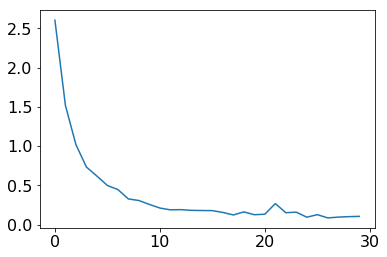

In [29]:
plt.plot(network.history.history['val_loss'])

Load test data

In [30]:
data_red_river = loadmat('red_river.mat')
vel_red = data_red_river['vel_ref']
prof_red = data_red_river['depth_ref']

Divide test data to input samples

In [31]:
X, Y = model_data.gen_test_data(vel=vel_red.reshape(-1, 1), dep=prof_red.reshape(-1, 1))

Make predictions for test input samples

In [32]:
velocity_dnn = network.predict(X)

491/491 [==============================] - 0s 867us/step


Post process the outputs of network (the outputs are profile depth for small boxes or only the principle components for small boxes. So, they need to be processed to provide a single river profile)

In [33]:
velocity_dnn.shape

(491, 82)

In [34]:
velocity_x = model_data.post_process(velocity_dnn[:,:41])
velocity_y = model_data.post_process(velocity_dnn[:,41:])

In [35]:
def xy_vel_sep(prof_vel):

        N, n_prof = prof_vel.shape
        x_vel = np.zeros((N//2, n_prof))
        y_vel = np.zeros((N//2, n_prof))
        mag_vel = np.zeros((N//2, n_prof))
        for i in range(n_prof):
            x_vel[:, i] = prof_vel[0::2, i]
            y_vel[:, i] = prof_vel[1::2, i]
            mag_vel[:, i] = np.sqrt(x_vel[:, i]**2+y_vel[:, i]**2)

        return x_vel, y_vel, mag_vel

In [36]:
x_vel, y_vel, mag_vel = xy_vel_sep(vel_red.T)

### Plotting the predicted x component of velocity

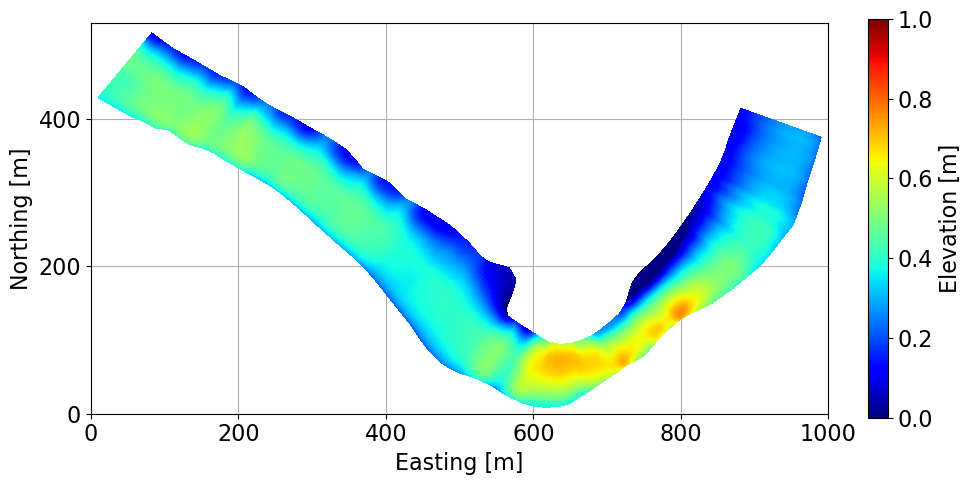

In [37]:
model_data.plt_im_tri(velocity_x.ravel(), 'v_x_predicted.jpg', False, vmin_=.0, vmax_=1.0)

### Plotting the true x component of velocity

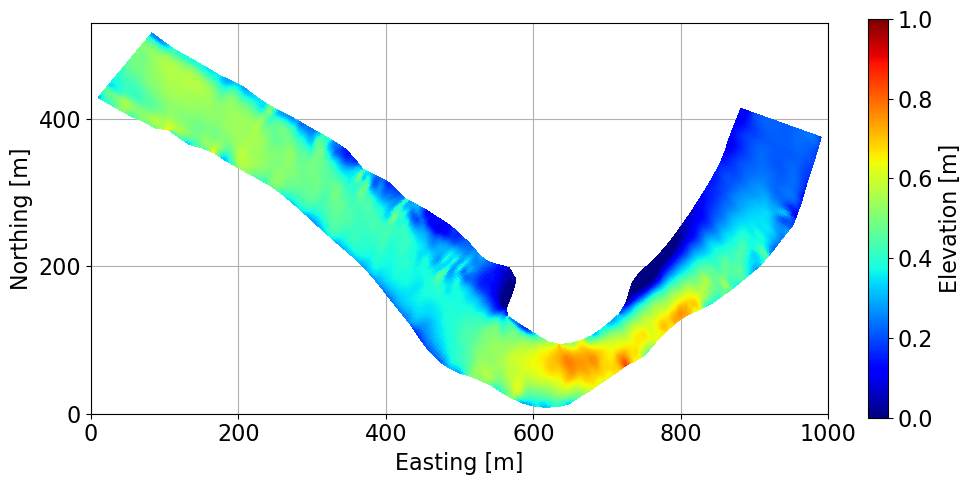

In [38]:
model_data.plt_im_tri(x_vel.ravel(), 'v_x_true.jpg', False, vmin_=.0, vmax_=1.0)

### Plotting the predicted y component of velocity

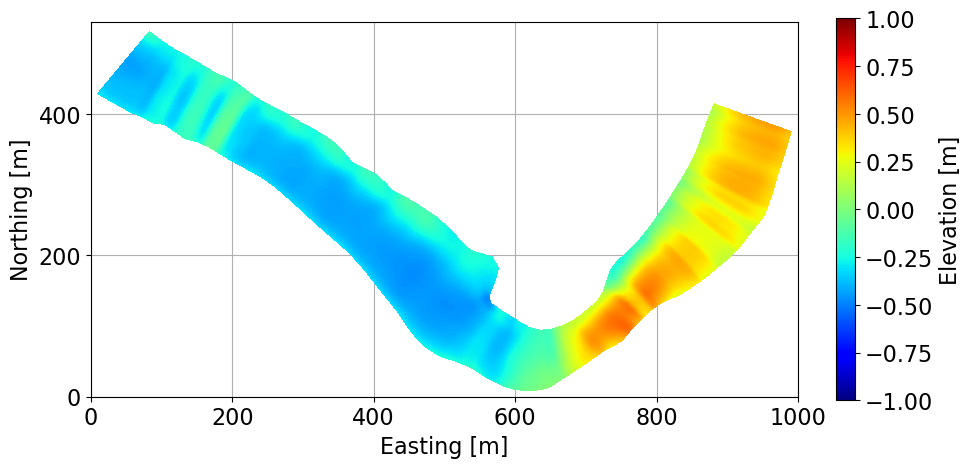

In [39]:
model_data.plt_im_tri(velocity_y.ravel(), 'v_y_predicted.jpg', False, vmin_=-1.0, vmax_=1.0)

### Plotting the true y component of velocity

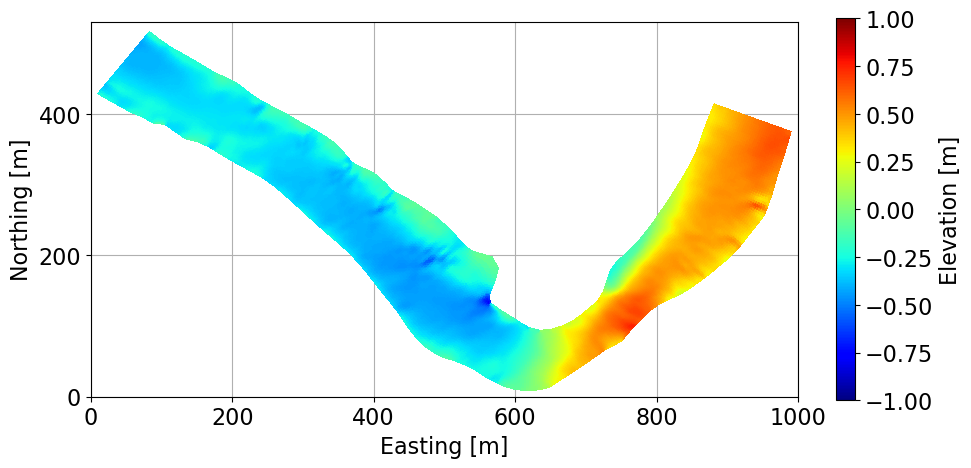

In [40]:
model_data.plt_im_tri(y_vel.ravel(), 'v_x_true.jpg', False, vmin_=-1.0, vmax_=1.0)